This script is used for:
- find a point where its nearest point is in another region

**How to launch this Jupyter notebook**:   
```bash
execcasper -A your_project -l gpu_type=v100 -l walltime=06:00:00 -l select=1:ncpus=18:mpiprocs=36:ngpus=1:mem=300GB
bash aws_urban_env.sh
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import gc
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patches
rc={'axes.labelsize': 12,
    'font.size': 12, 'legend.fontsize': 12, 
    'axes.titlesize': 12,
    'xtick.labelsize': 12.0,
    'ytick.labelsize': 12.0}
plt.rcParams.update(**rc)

def lon_to_360(lon):
    """This is a function for converting input city's lon from (-180, 180) to (0, 360)
    ref: https://gis.stackexchange.com/questions/201789/verifying-formula-that-will-convert-longitude-0-360-to-180-to-180/201793
    
    Parameters
    ----------
    lon : float
        longitude ranges from -180 to 180
    Returns
    -------
    float
        longitude ranges from 0 to 360
    """
    return lon*1.0%360

# urban_surf_path = "/glade/scratch/zhonghua/urban_params/urban_surface.parquet.gzip"
urban_surf_path = "/home/zhonghua/UrbFLAM//urban_params/urban_surface.nc"

region_path = "/home/zhonghua/UrbFLAM/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1850_c190214.nc"

In [2]:
member="003"
TREFMXAV_U = xr.open_dataset("/home/zhonghua/UrbFLAM/b.e11.BRCP85C5CNBDRD.f09_g16.003.clm2.h1.TREFMXAV_U.20060101-20801231.nc")
# get the clm latitude
CLM_lat = TREFMXAV_U.indexes['lat']
# get the mask of clm
mask = TREFMXAV_U["TREFMXAV_U"].loc["2006-01-02"].notnull().squeeze().drop("time")

In [3]:
ds_param = xr.open_dataset(urban_surf_path)\
             .rename_dims({"lsmlat":"lat", "lsmlon":"lon"})\
             .assign_coords(lat = mask.lat, lon = mask.lon).where(mask)
ds_r = xr.open_dataset(region_path)\
         .rename_dims({"lsmlat":"lat", "lsmlon":"lon"})\
         .assign_coords(lat = mask.lat, lon = mask.lon).where(mask)
ds = xr.merge([ds_param,ds_r["URBAN_REGION_ID"]])

surf_params_ls = list(ds_param)

del ds_param, ds_r
gc.collect()

147

In [4]:
ds["URBAN_REGION_ID"].to_dataframe().drop_duplicates().sort_values("URBAN_REGION_ID")

URBAN_REGION_ID
lat        lon                    
-33.455498 152.50              0.0
 57.958115 207.50              1.0
-42.879581 147.50              2.0
-33.455498 307.50              3.0
-12.722513 13.75               4.0
 37.225132 60.00               5.0
 41.937172 277.50              6.0
 18.376963 281.25              7.0
           108.75              8.0
-25.916231 32.50               9.0
 22.146597 120.00             10.0
 40.052357 20.00              11.0
 8.010471  77.50              13.0
           277.50             14.0
 12.722513 43.75              15.0
 4.240838  30.00              16.0
 37.225132 271.25             17.0
 38.167538 272.50             18.0
 50.418850 355.00             19.0
 42.879581 247.50             20.0
-46.649216 168.75             21.0
 41.937172 47.50              22.0
-34.397907 18.75              23.0
 6.125654  80.00              24.0
 26.858639 261.25             25.0
 25.916231 278.75             26.0
-9.895288  118.75             27.0
 27.801046 346.25             28.0
 31.570681 248.75             29.0
-54.188480 292.50             30.0
-18.376963 296.25             31.0
 4.240838  6.25               32.0
 41.937172 8.75               33.0
-90.000000 0.00                NaN

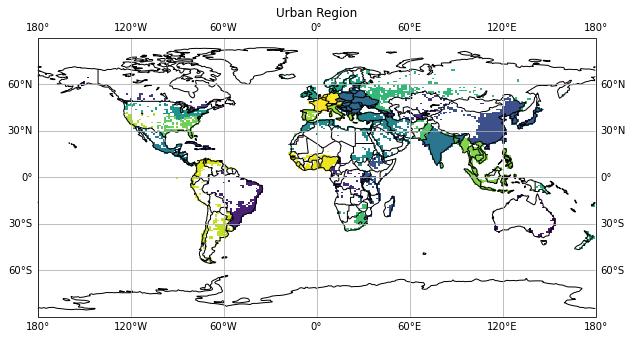

In [4]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())
ds["URBAN_REGION_ID"].plot(ax=ax, add_colorbar=False)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
ax.gridlines(draw_labels=True)
ax.set_title("Urban Region")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("urban_region.pdf", dpi=188, bbox_inches='tight')
plt.show()

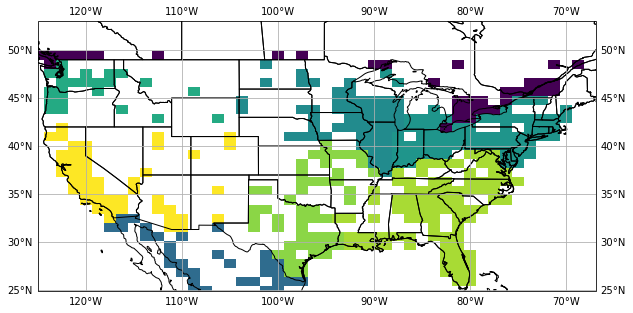

In [5]:
# bounding boxes: https://gist.github.com/graydon/11198540
lat_min = 24.9493; lat_max = 49.5904
lon_min = lon_to_360(-125.0011); lon_max = lon_to_360(-66.9326)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ds["URBAN_REGION_ID"].sel(
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
).plot(ax=ax, add_colorbar=False)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.gridlines(draw_labels=True)
plt.show()

In [6]:
## known gridcell (lat, lon) <-> test gridcell (lat, lon)
known_gridcell = {
    "1": {"lat":32.51309, "lon":253.75},
    "2": {"lat":40.994766, "lon":277.5},
    "3": {"lat":40.994766, "lon":247.5}
}

pred_gridcell = {
    "1": {"lat":31.57068, "lon":253.75},
    "2": {"lat":41.937172, "lon":277.5},
    "3": {"lat":42.87958, "lon":247.5}
}

known_gridcell_lat = [known_gridcell[p]["lat"] for p in known_gridcell]
known_gridcell_lon = [known_gridcell[p]["lon"] for p in known_gridcell]
pred_gridcell_lat = [pred_gridcell[p]["lat"] for p in pred_gridcell]
pred_gridcell_lon = [pred_gridcell[p]["lon"] for p in pred_gridcell]

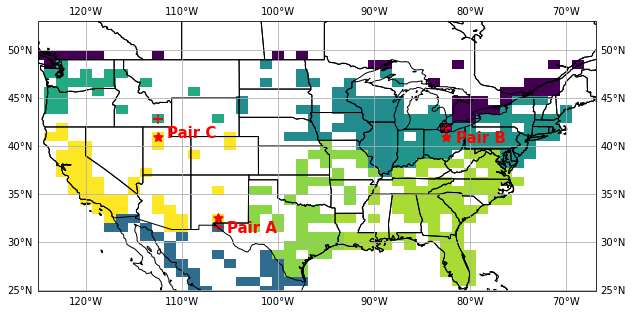

In [32]:
# bounding boxes: https://gist.github.com/graydon/11198540
lat_min = 24.9493; lat_max = 49.5904
lon_min = lon_to_360(-125.0011); lon_max = lon_to_360(-66.9326)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ds["URBAN_REGION_ID"].sel(
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
).plot(ax=ax, add_colorbar=False)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.gridlines(draw_labels=True)

ax.scatter(x=known_gridcell_lon, y=known_gridcell_lat,
           c="r", transform=ccrs.PlateCarree(),s=100, marker=(5, 1))

ax.scatter(x=pred_gridcell_lon, y=pred_gridcell_lat,
           c="r", transform=ccrs.PlateCarree(),s=100, marker="+")

grid_name = ["Pair A", "Pair B", "Pair C"]
for i in known_gridcell:
    ax.text((known_gridcell[i]["lon"] + pred_gridcell[i]["lon"])/2 + 1,
            (known_gridcell[i]["lat"] + pred_gridcell[i]["lat"])/2 - 1,
            grid_name[int(i)-1],
            fontsize=15, 
            color="Red", 
            fontdict={"weight":"bold"},
            transform=ccrs.PlateCarree())

plt.savefig("urban_region_selected_cities.pdf", dpi=188, bbox_inches='tight')
plt.show()